In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [2]:
def compute_delta(I, direction):
    assert direction in ["n", "s", "e", "w"]
    # compute I(i-1, j) - I(i, j) for each pixel
    if direction == "n":
        zeros_col = np.zeros((I.shape[0], 1))
        shifted_I = np.concatenate((zeros_col, I[:, :-1]), axis=1)
        return shifted_I - I
    # compute I(i+1, j) - I(i, j) for each pixel
    if direction == "s":
        zeros_col = np.zeros((I.shape[0], 1))
        shifted_I = np.concatenate((I[:, 1:], zeros_col), axis=1)
        return shifted_I - I
    # compute I(i, j+1) - I(i, j) for each pixel
    if direction == "e":
        zeros_row = np.zeros((1, I.shape[1]))
        shifted_I = np.concatenate((zeros_row, I[:-1]))
        return shifted_I - I
    # compute I(i, j-1) - I(i, j) for each pixel
    if direction == "w":
        zeros_row = np.zeros((1, I.shape[1]))
        shifted_I = np.concatenate((I[1:], zeros_row))
        return shifted_I - I


def compute_B(image, C, bins=1000):
    assert 0 <= C <= 100
    def sobel3x3_ver(K):
        return np.array([[1], [0], [-1]]) @ np.array([[1, K, 1]])

    def sobel3x3_hor(K):
        return np.array([[1], [K], [1]]) @ np.array([[-1, 0, 1]])
    K = 2
    sobel_ver_mask = sobel3x3_ver(K)
    sobel_hor_mask = sobel3x3_hor(K)

    # Compute the gradients and the gradient magnitude using Sobel masks
    ver_grad = cv2.filter2D(src=image, ddepth=-1, kernel=sobel_ver_mask)
    hor_grad = cv2.filter2D(src=image, ddepth=-1, kernel=sobel_hor_mask)
    grad_mag = np.sqrt(ver_grad**2 + hor_grad**2).flatten().astype(np.float64)

    # Plot the histogram of gradient magnitudes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.hist(grad_mag, bins=bins, edgecolor="black")
    ax1.set_title("Histogram of gradient magnitudes")
    ax1.set_xlabel("Gradient Magnitude")
    ax1.set_ylabel("Number of Pixels")
    
    # Show the grayscale image
    ax2.imshow(image, cmap='gray')
    ax2.set_title('Image')
    ax2.axis('off')

    plt.show()

    return np.percentile(grad_mag, C)


def g(dI, B):
    assert B > 0
    return np.exp(-((dI / B) ** 2))


def anisotropic_diffusion(image, B, lam=0.25):
    assert 0 < lam and lam <= 0.25

    delta_n = compute_delta(image, "n")
    delta_s = compute_delta(image, "s")
    delta_e = compute_delta(image, "e")
    delta_w = compute_delta(image, "w")

    image = image + lam * (
        g(delta_n, B) * delta_n
        + g(delta_s, B) * delta_s
        + g(delta_e, B) * delta_e
        + g(delta_w, B) * delta_w
    )
    return image

In [3]:
image = cv2.imread('assets/test.png')  # Replace with the path to your image file
# Convert the image from BGR (OpenCV default) to grayscale
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

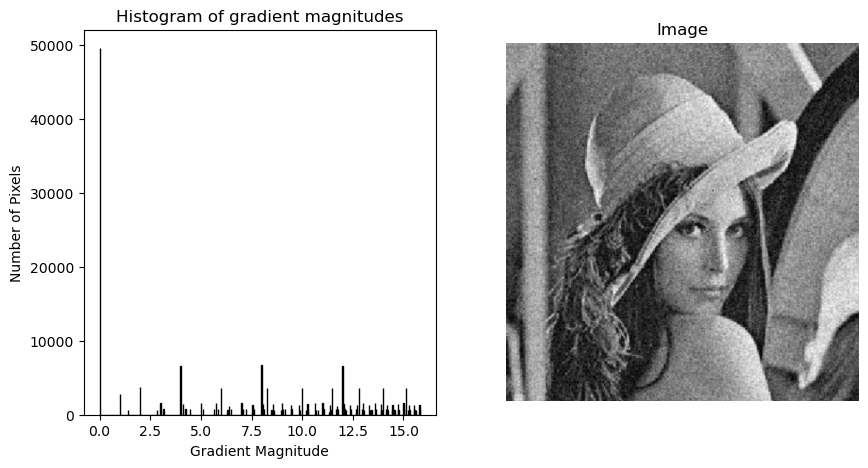

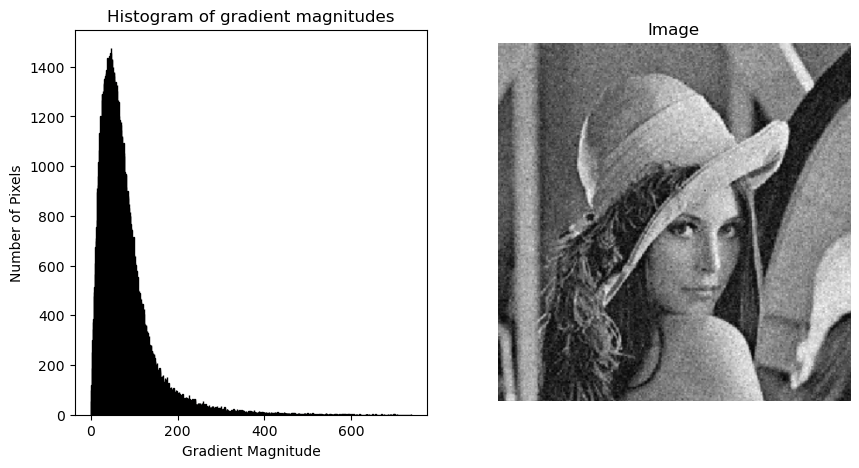

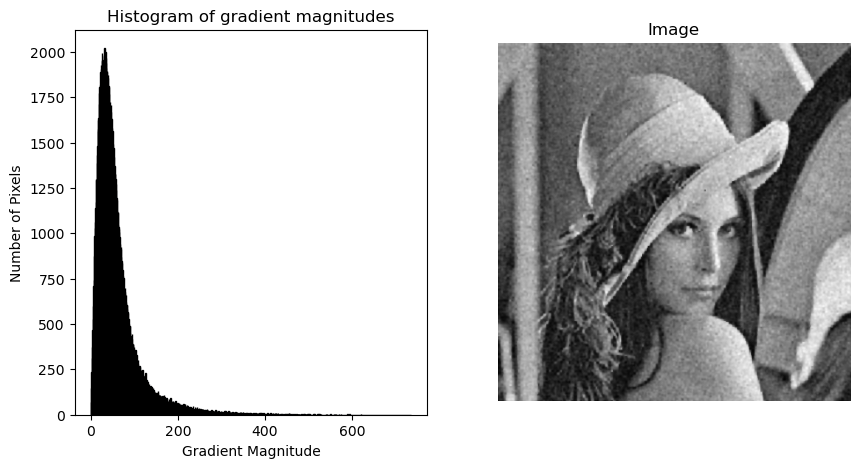

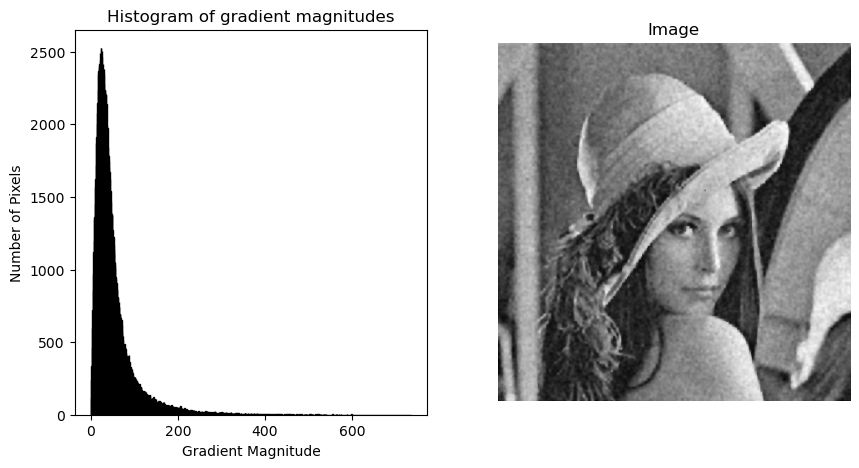

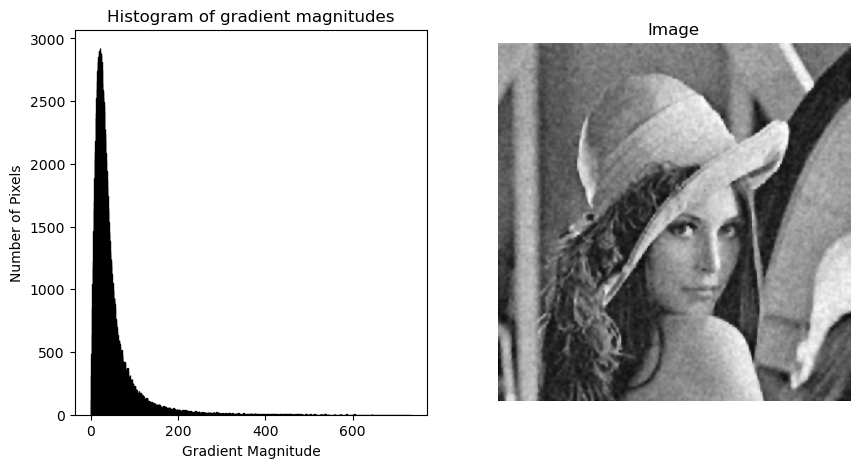

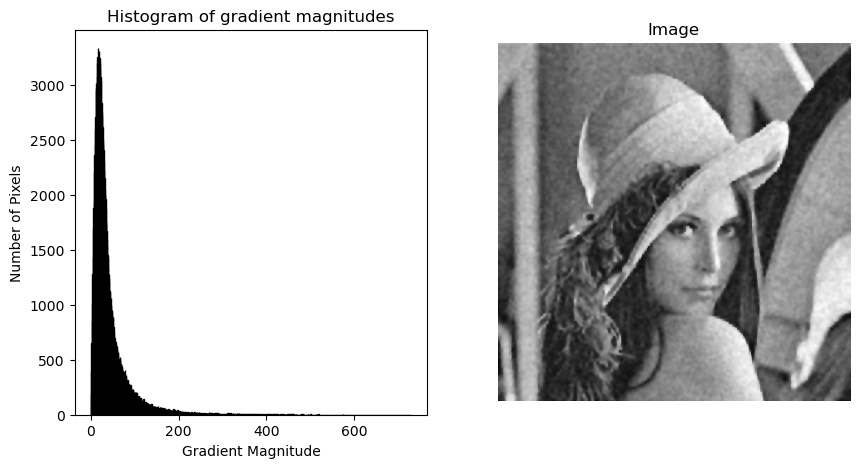

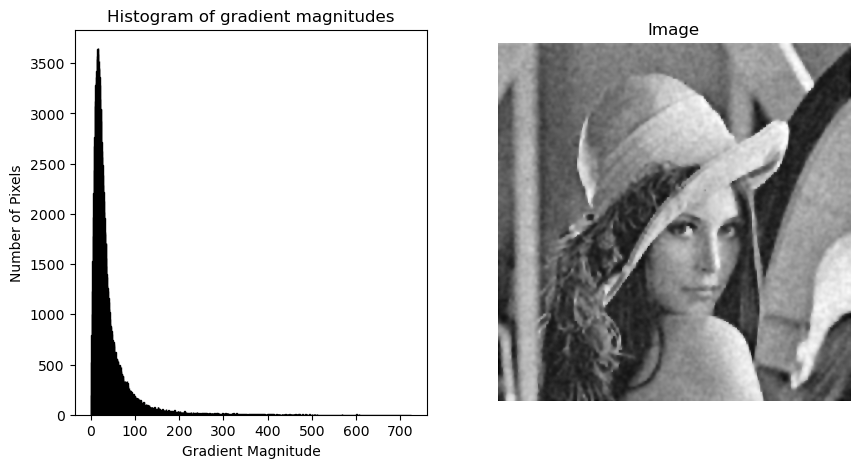

In [4]:
num_iters = 7
for i in range(7):
    B = compute_B(image, C=50)
    image = anisotropic_diffusion(image, B)